# TCGA-BRCA Dashboard Analysis

## 1. Load Expression & Clinical Data
- Load `data_mrna_seq_v2_rsem.txt`
- Load `brca_tcga_pan_can_atlas_2018_clinical_data.tsv`

## 2. Merge by Sample ID
- Match expression columns to clinical `Sample ID`
- Keep samples with non-null `Subtype`

## 3. PCA Visualization
- PCA on top 1000 most variable genes
- Color by Subtype

## 4. Volcano Plot (e.g., Basal vs Luminal A)
- Log2 fold change vs p-value (t-test or Wilcoxon)

## 5. Heatmap
- Top 50 most variable genes

## 6. (Optional) ML Classifier Scaffold
- XGBoost classifier (Subtype prediction)

## 7. Save Outputs & Next Steps

In [1]:
# TCGA-BRCA Dashboard Analysis

## 1. Load Expression & Clinical Data

!pip install pandas numpy matplotlib seaborn scikit-learn scipy statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Expression matrix (RSEM values)
expr_path = "/mnt/c/Users/91986/Downloads/brca_tcga_pan_can_atlas_2018/brca_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem.txt" 

# Clinical data 
clinical_path = "/mnt/c/Users/91986/Downloads/brca_tcga_pan_can_atlas_2018_clinical_data.tsv"
 
print("Loading expression data...")
expr_df = pd.read_csv(expr_path, sep='\t', index_col=0)

print("Expression matrix shape:", expr_df.shape)
print(expr_df.iloc[:5, :5])  # Show a preview of first 5 genes × first 5 samples
print(f" Genes: {expr_df.index[:3].tolist()}...")
print(f" Sample IDs (columns): {expr_df.columns[:3].tolist()}...")

expr_df.head()


Loading expression data...
Expression matrix shape: (20531, 1083)
             Entrez_Gene_Id  TCGA-3C-AAAU-01  TCGA-3C-AALI-01  \
Hugo_Symbol                                                     
NaN               100130426           0.0000           0.0000   
NaN               100133144          16.3644           9.2659   
UBE2Q2P2          100134869          12.9316          17.3790   
HMGB1P1               10357          52.1503          69.7553   
NaN                   10431         408.0760         563.8930   

             TCGA-3C-AALJ-01  TCGA-3C-AALK-01  
Hugo_Symbol                                    
NaN                   0.9066           0.0000  
NaN                  11.6228          12.0894  
UBE2Q2P2              9.2294          11.0799  
HMGB1P1             154.2970         143.8640  
NaN                1360.8300         865.5360  
 Genes: [nan, nan, 'UBE2Q2P2']...
 Sample IDs (columns): ['Entrez_Gene_Id', 'TCGA-3C-AAAU-01', 'TCGA-3C-AALI-01']...


,Entrez_Gene_Id,TCGA-3C-AAAU-01,TCGA-3C-AALI-01,TCGA-3C-AALJ-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01,TCGA-5L-AAT0-01,TCGA-5T-A9QA-01,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,...,TCGA-UL-AAZ6-01,TCGA-UU-A93S-01,TCGA-V7-A7HQ-01,TCGA-W8-A86G-01,TCGA-WT-AB41-01,TCGA-WT-AB44-01,TCGA-XX-A899-01,TCGA-XX-A89A-01,TCGA-Z7-A8R5-01,TCGA-Z7-A8R6-01
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
NaN,100130426,0.0000,0.0000,0.9066,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
NaN,100133144,16.3644,9.2659,11.6228,12.0894,6.8468,3.9889,1.4644,15.3396,9.5178,...,0.3992,4.3126,0.0000,5.5624,0.0000,0.0000,14.3858,22.3240,2.2638,6.8865
UBE2Q2P2,100134869,12.9316,17.3790,9.2294,11.0799,14.4298,13.6090,8.9958,14.3935,11.3241,...,14.3720,10.8828,3.0792,14.3711,6.3091,3.2580,21.4409,27.2744,7.2933,24.7795
HMGB1P1,10357,52.1503,69.7553,154.2970,143.8640,84.2128,114.2570,107.5630,116.3870,60.2630,...,135.6240,136.1290,29.9974,128.3150,53.6278,42.2643,137.7760,64.1427,85.0461,167.5510
NaN,10431,408.0760,563.8930,1360.8300,865.5360,766.3830,807.7430,1420.5000,657.2810,977.9180,...,1570.1400,2886.4000,1721.8800,697.6740,1245.2700,1877.4200,652.7560,722.7210,1140.2800,1003.5700


In [3]:
print("\nLoading clinical metadata...")
clinical_df = pd.read_csv(clinical_path, sep='\t')

# Keep only key columns
clinical_df = clinical_df[[
    "Sample ID",
    "Subtype",
    "Overall Survival (Months)",
    "Overall Survival Status"
]]

# Drop samples without subtype info
clinical_df = clinical_df.dropna(subset=["Subtype"])

# Clean subtype column (remove whitespace)
clinical_df["Subtype"] = clinical_df["Subtype"].str.strip()

# Inspect clinical metadata
print(f"✅ Clinical samples with subtype: {clinical_df.shape[0]}")
print(clinical_df["Subtype"].value_counts())

clinical_df.head()


Loading clinical metadata...
✅ Clinical samples with subtype: 981
Subtype
BRCA_LumA      499
BRCA_LumB      197
BRCA_Basal     171
BRCA_Her2       78
BRCA_Normal     36
Name: count, dtype: int64


,Sample ID,Subtype,Overall Survival (Months),Overall Survival Status
0,TCGA-3C-AAAU-01,BRCA_LumA,133.050597,0:LIVING
1,TCGA-3C-AALI-01,BRCA_Her2,131.669790,0:LIVING
2,TCGA-3C-AALJ-01,BRCA_LumB,48.459743,0:LIVING
3,TCGA-3C-AALK-01,BRCA_LumA,47.604958,0:LIVING
4,TCGA-4H-AAAK-01,BRCA_LumA,11.440971,0:LIVING


In [4]:
clinical_df["Subtype"].unique()

array(['BRCA_LumA', 'BRCA_Her2', 'BRCA_LumB', 'BRCA_Normal', 'BRCA_Basal'],
      dtype=object)

In [5]:
expr_df.index.isnull().sum()

13

In [6]:
expr_df = expr_df[expr_df.index.notna()].copy()

print("✅ Removed unnamed genes. New shape:", expr_df.shape)

✅ Removed unnamed genes. New shape: (20518, 1083)


In [7]:
common_samples = list(set(clinical_df["Sample ID"]).intersection(expr_df.columns))
expr_matched = expr_df[common_samples]
clinical_matched = clinical_df[clinical_df["Sample ID"].isin(common_samples)].copy()


This step syncs the two datasets so that we only keep patient samples that are present in both the gene expression matrix and the clinical annotations

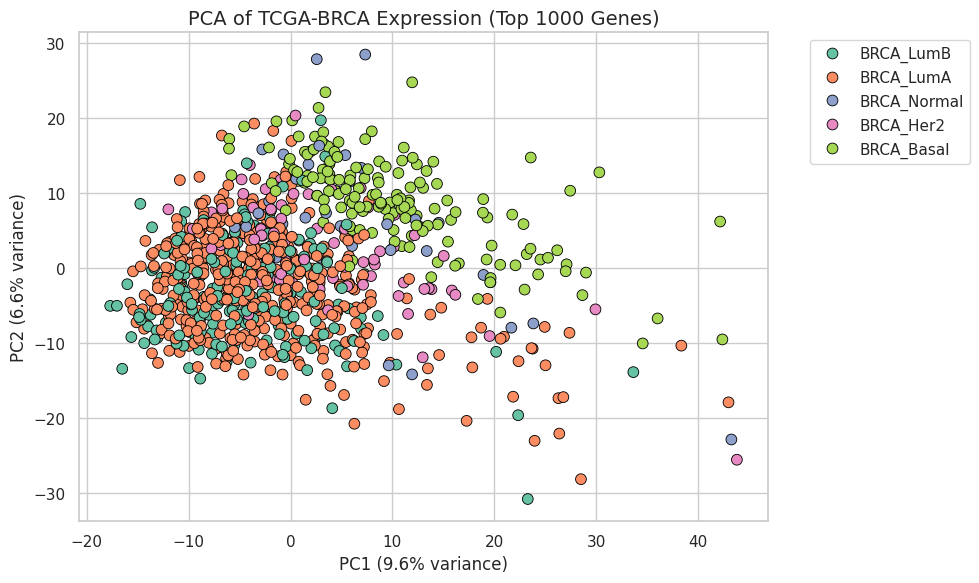

In [8]:
# PCA Visualization

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Filter top 1000 most variable genes

expr_var = expr_matched.var(axis=1)
top_genes = expr_var.sort_values(ascending=False).head(1000).index
expr_top = expr_matched.loc[top_genes].T  # transpose to samples x genes

# Step 2: Standardize (z-score)

scaler = StandardScaler()
expr_scaled = scaler.fit_transform(expr_top)

# Step 3: PCA (2 components)

pca = PCA(n_components=2)
pca_coords = pca.fit_transform(expr_scaled)

pca_df = pd.DataFrame(pca_coords, columns=["PC1", "PC2"])
pca_df["Sample ID"] = expr_top.index

# Step 4: Merge PCA + Clinical Subtype

pca_df = pca_df.merge(clinical_df[["Sample ID", "Subtype"]], on="Sample ID")

# Step 5: Plot

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2",
    hue="Subtype",
    palette="Set2",
    s=60,
    edgecolor="black"
)
plt.title("PCA of TCGA-BRCA Expression (Top 1000 Genes)", fontsize=14)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

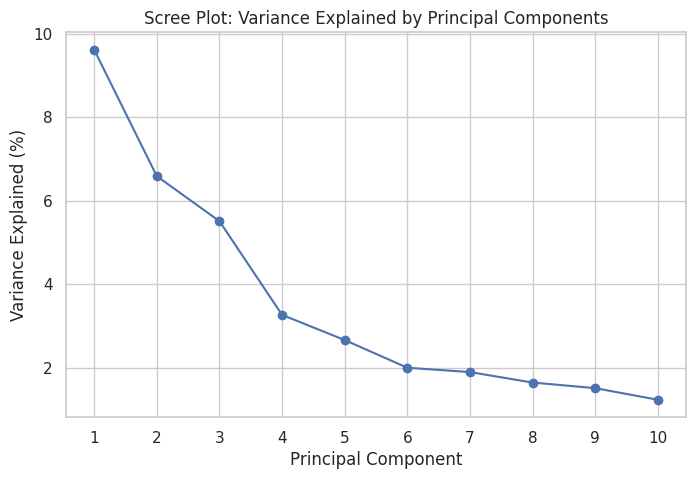

In [9]:
# PCA with more components
pca = PCA(n_components=10)
pca.fit(expr_scaled)

explained = pca.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), explained * 100, marker='o')
plt.title("Scree Plot: Variance Explained by Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.grid(True)
plt.xticks(range(1, 11))
plt.show()

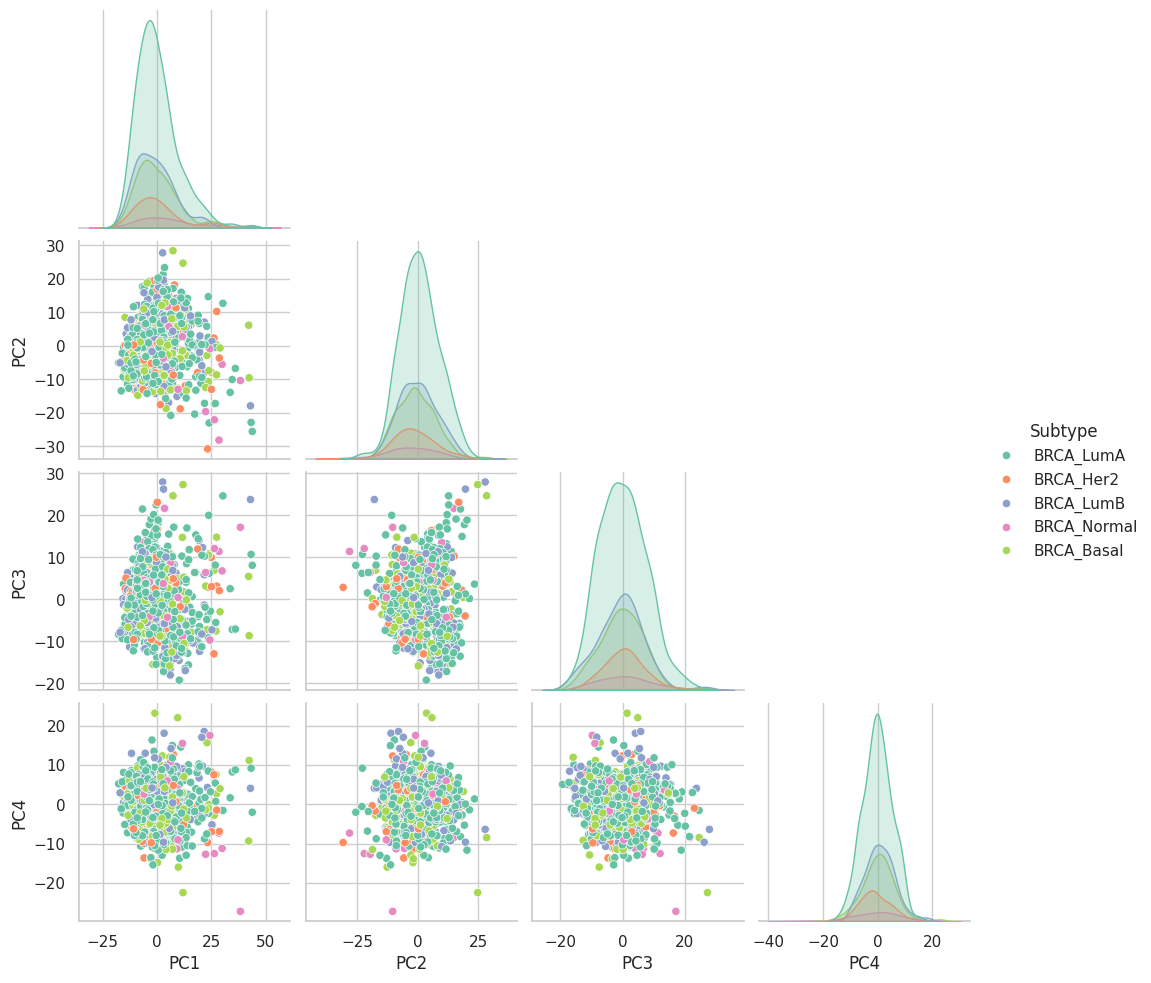

In [10]:
import seaborn as sns
import pandas as pd

pca_full = PCA(n_components=4)
components = pca_full.fit_transform(expr_scaled)

pca_pair_df = pd.DataFrame(components, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_pair_df['Subtype'] = clinical_matched['Subtype'].values

sns.pairplot(pca_pair_df, hue='Subtype', corner=True, palette="Set2")


Each dot here is a patient sample. We’re looking at how their gene expression compares across different principal axes (PC1, PC2, PC3...). Some cancer subtypes like Basal seem to cluster slightly differently, especially along PC1. Others, like Luminal A and B, are more mixed — which is expected since they’re biologically close

Type first subtype or enter for default(default = BRCA_Basal):  
Type second subtype or enter for default(default = BRCA_LumA):  


🔍 Running volcano plot: BRCA_Basal vs BRCA_LumA


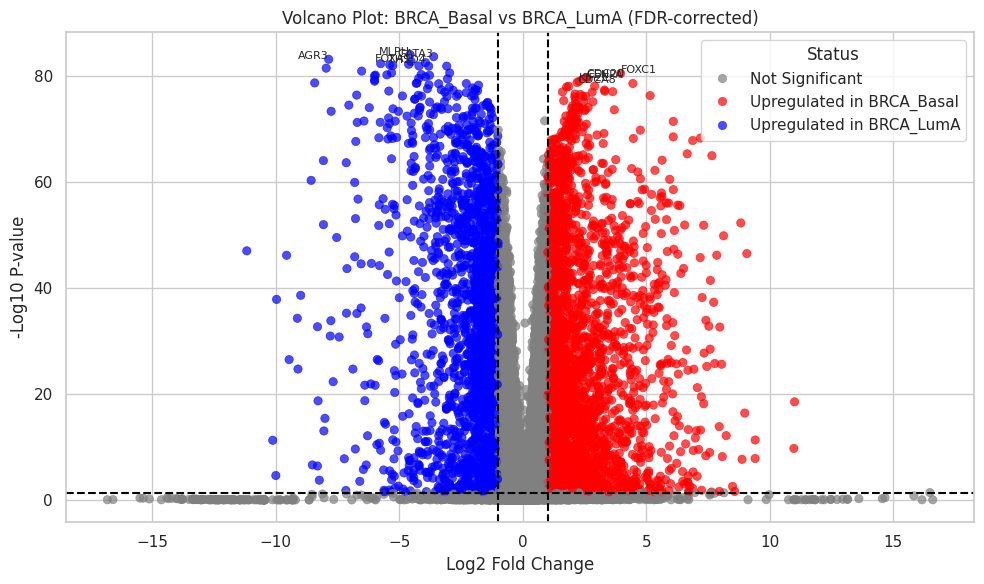

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests

# --- Step 0: Get user input with default ---
sub1 = input("Type first subtype or enter for default(default = BRCA_Basal): ").strip() or "BRCA_Basal"
sub2 = input("Type second subtype or enter for default(default = BRCA_LumA): ").strip() or "BRCA_LumA"
print(f"🔍 Running volcano plot: {sub1} vs {sub2}")

# --- Step 1: Subset expression data ---
group1_ids = clinical_matched[clinical_matched["Subtype"] == sub1]["Sample ID"]
group2_ids = clinical_matched[clinical_matched["Subtype"] == sub2]["Sample ID"]
expr1 = expr_matched[group1_ids]
expr2 = expr_matched[group2_ids]

# --- Step 2: Compute log2FC and p-values ---
log2_fc = []
pvals = []

for gene in expr_matched.index:
    g1 = expr1.loc[gene].dropna().values
    g2 = expr2.loc[gene].dropna().values

    fc = np.log2((g1.mean() + 1e-6) / (g2.mean() + 1e-6))
    log2_fc.append(fc)

    if len(g1) > 1 and len(g2) > 1:
        try:
            stat, p = ranksums(g1, g2)
        except ValueError:
            p = 1.0
    else:
        p = 1.0
    pvals.append(p)

# --- Step 3: Create volcano DataFrame ---
df = pd.DataFrame({
    "Gene": expr_matched.index,
    "log2FC": log2_fc,
    "pval": pvals
})
df["-log10(pval)"] = -np.log10(df["pval"])

# --- Step 4: Add FDR correction ---
df["FDR"] = multipletests(df["pval"], method='fdr_bh')[1]

# --- Step 5: Label regulation status ---
df["Status"] = "Not Significant"
df.loc[(df["log2FC"] > 1) & (df["FDR"] < 0.05), "Status"] = f"Upregulated in {sub1}"
df.loc[(df["log2FC"] < -1) & (df["FDR"] < 0.05), "Status"] = f"Upregulated in {sub2}"

# --- Step 6: Get top 5 genes from each group ---
top_sub1 = df[df["Status"] == f"Upregulated in {sub1}"].nsmallest(5, "FDR")
top_sub2 = df[df["Status"] == f"Upregulated in {sub2}"].nsmallest(5, "FDR")
top_genes = pd.concat([top_sub1, top_sub2])

# --- Step 7: Plot volcano with labels ---
palette = {
    f"Upregulated in {sub1}": "red",
    f"Upregulated in {sub2}": "blue",
    "Not Significant": "grey"
}

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x="log2FC", y="-log10(pval)",
    hue="Status",
    palette=palette,
    alpha=0.7, edgecolor=None
)

plt.axhline(-np.log10(0.05), ls='--', color='black')
plt.axvline(-1, ls='--', color='black')
plt.axvline(1, ls='--', color='black')

# Annotate top genes
for _, row in top_genes.iterrows():
    plt.text(row["log2FC"], row["-log10(pval)"], row["Gene"],
             fontsize=8, ha='right' if row["log2FC"] < 0 else 'left')

plt.title(f"Volcano Plot: {sub1} vs {sub2} (FDR-corrected)")
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10 P-value")
plt.tight_layout()

# Save volcano plot
plot_filename = f"tcga-brca-dashboard/results/volcano_plots/{sub1}_vs_{sub2}_volcano.png"
plt.savefig(plot_filename, dpi=300)

plt.show()

In [12]:
# Upregulated in sub1
#top_genes_sub1 = df[df["Status"] == f"Upregulated in {sub1}"].sort_values("FDR").head(200)["Gene"]

# Save to text file (one gene per line)
#top_genes_sub1.to_csv(f"DEGs_upregulated_in_{sub1}.txt", index=False, header=False)


In [13]:
df[df["FDR"] < 0.05].sort_values("FDR").to_csv(f"tcga-brca-dashboard/results/top_DEGs_{sub1}_vs_{sub2}.csv", index=False)


In [14]:
!pip install gseapy
from gseapy import enrichr

# Get top 200 genes upregulated in sub1
top_genes_sub1 = df[df["Status"] == f"Upregulated in {sub1}"].sort_values("FDR").head(200)["Gene"]
gene_list = top_genes_sub1.tolist()


Defaulting to user installation because normal site-packages is not writeable


In [15]:
# Run enrichment for GO Biological Process and KEGG
results = enrichr(
    gene_list=gene_list,
    gene_sets=['KEGG_2021_Human', 'GO_Biological_Process_2021'],
    organism='Human',
    outdir='enrichr_results',     # folder to save outputs
    cutoff=0.05                   # show only adjusted p < 0.05
)
